In [2]:
from strat_a.data_loader import DataLoader
from utilities.options_calendar_spread.btc_futures_backtest import run_calendar_spreads, CalendarConfig, parameter_sensitivity, regime_performance, contract_usage

In [3]:
dl = DataLoader("data_collect/data/raw")  # prints what files it found
dl.summary()                    # full data overview

DataLoader: data_collect\data\raw
  Found:   binance_spot, binance_perp, binance_funding, binance_quarterly, binance_contracts, deribit_perp, deribit_funding, deribit_quarterly, hyperliquid_funding, hyperliquid_perp, dydx_funding, dydx_perp
  Missing: deribit_contracts

DATA SUMMARY
  ⚠ Repaired 8760 rows with μs timestamps → ms

  Binance Spot: 35,063 rows  |  2022-01-01 → 2025-12-31
    Price: $15,650 – $126,011

  Binance Perp: 35,065 rows  |  2022-01-01 → 2025-12-31
    Price: $15,638 – $125,986

  Binance Funding: 4,383 rows  |  2022-01-01 → 2025-12-31
    Funding: mean=0.000066  min=-0.001192  max=0.000881

  Binance Quarterly: 87,369 rows  |  2022-01-01 → 2025-12-31
    Price: $15,612 – $130,961
    Contracts: 25 (BTCUSDT_220325, BTCUSDT_220624, BTCUSDT_220930, BTCUSDT_221230, BTCUSDT_230331...)

  Deribit Perp: 5,001 rows  |  2025-06-06 → 2025-12-31
    Price: $82,089 – $126,143

  Deribit Funding: 35,063 rows  |  2022-01-01 → 2025-12-31
    Funding: mean=0.000046  min=-0.00219

In [4]:
# Raw data
spot = dl.spot()
futures = dl.quarterly_futures(margin_type="USDT-M")

# Basis for every contract at every hour
basis = dl.basis_table()
basis.head(10)
#datetime, spot_close, futures_close, basis_pct, annualized_basis_pct, days_to_expiry

,datetime,spot_close,symbol,futures_close,expiry_date,margin_type,venue,days_to_expiry,basis,basis_pct,annualized_basis_pct
0,2022-01-01 00:00:00+00:00,46656.13,BTCUSDT_220325,47687.6,2022-03-25,USDT-M,binance,83.000000,1031.47,2.210792,9.728817
1,2022-01-01 01:00:00+00:00,46778.14,BTCUSDT_220325,47780.7,2022-03-25,USDT-M,binance,82.958333,1002.56,2.143223,9.436211
2,2022-01-01 02:00:00+00:00,46811.77,BTCUSDT_220325,47816.8,2022-03-25,USDT-M,binance,82.916667,1005.03,2.146960,9.457413
3,2022-01-01 03:00:00+00:00,46813.20,BTCUSDT_220325,47809.8,2022-03-25,USDT-M,binance,82.875000,996.60,2.128887,9.382514
4,2022-01-01 04:00:00+00:00,46711.05,BTCUSDT_220325,47736.2,2022-03-25,USDT-M,binance,82.833333,1025.15,2.194663,9.677270
5,2022-01-01 05:00:00+00:00,47192.55,BTCUSDT_220325,48230.1,2022-03-25,USDT-M,binance,82.791667,1037.55,2.198546,9.699273
6,2022-01-01 06:00:00+00:00,46979.62,BTCUSDT_220325,48006.0,2022-03-25,USDT-M,binance,82.750000,1026.38,2.184735,9.643194
7,2022-01-01 07:00:00+00:00,47194.73,BTCUSDT_220325,48249.7,2022-03-25,USDT-M,binance,82.708333,1054.97,2.235356,9.871600
8,2022-01-01 08:00:00+00:00,47124.82,BTCUSDT_220325,48194.7,2022-03-25,USDT-M,binance,82.666667,1069.88,2.270311,10.031022
9,2022-01-01 09:00:00+00:00,47143.98,BTCUSDT_220325,48151.3,2022-03-25,USDT-M,binance,82.625000,1007.32,2.136689,9.445392


In [5]:
# Continuous front-month series (auto-rolls 5 days before expiry)
front = dl.continuous_front_month()
front.head(10)

,datetime,spot_close,symbol,futures_close,expiry_date,margin_type,venue,days_to_expiry,basis,basis_pct,annualized_basis_pct
0,2022-01-01 00:00:00+00:00,46656.13,BTCUSDT_220325,47687.6,2022-03-25,USDT-M,binance,83.000000,1031.47,2.210792,9.728817
1,2022-01-01 01:00:00+00:00,46778.14,BTCUSDT_220325,47780.7,2022-03-25,USDT-M,binance,82.958333,1002.56,2.143223,9.436211
2,2022-01-01 02:00:00+00:00,46811.77,BTCUSDT_220325,47816.8,2022-03-25,USDT-M,binance,82.916667,1005.03,2.146960,9.457413
3,2022-01-01 03:00:00+00:00,46813.20,BTCUSDT_220325,47809.8,2022-03-25,USDT-M,binance,82.875000,996.60,2.128887,9.382514
4,2022-01-01 04:00:00+00:00,46711.05,BTCUSDT_220325,47736.2,2022-03-25,USDT-M,binance,82.833333,1025.15,2.194663,9.677270
5,2022-01-01 05:00:00+00:00,47192.55,BTCUSDT_220325,48230.1,2022-03-25,USDT-M,binance,82.791667,1037.55,2.198546,9.699273
6,2022-01-01 06:00:00+00:00,46979.62,BTCUSDT_220325,48006.0,2022-03-25,USDT-M,binance,82.750000,1026.38,2.184735,9.643194
7,2022-01-01 07:00:00+00:00,47194.73,BTCUSDT_220325,48249.7,2022-03-25,USDT-M,binance,82.708333,1054.97,2.235356,9.871600
8,2022-01-01 08:00:00+00:00,47124.82,BTCUSDT_220325,48194.7,2022-03-25,USDT-M,binance,82.666667,1069.88,2.270311,10.031022
9,2022-01-01 09:00:00+00:00,47143.98,BTCUSDT_220325,48151.3,2022-03-25,USDT-M,binance,82.625000,1007.32,2.136689,9.445392


In [6]:
# Term structure at a specific date (all active contracts)
snap = dl.term_structure_snapshot("2024-06-15")
snap

,symbol,datetime,spot_close,futures_close,expiry_date,margin_type,venue,days_to_expiry,basis,basis_pct,annualized_basis_pct
0,BTCUSDT_240628,2024-06-15 23:00:00+00:00,66228.25,66441.6,2024-06-28,USDT-M,binance,12.041667,213.35,0.322143,9.771314
1,BTCUSDT_240927,2024-06-15 23:00:00+00:00,66228.25,68534.2,2024-09-27,USDT-M,binance,103.041667,2305.95,3.481822,12.341955


In [7]:
# Regime classification (steep_contango / mild_contango / flat / backwardation)
regimes = dl.classify_regime()
regimes["regime"].value_counts()

regime
mild_contango     17191
flat              11776
steep_contango     1305
backwardation        54
Name: count, dtype: int64


══════════════════════════════════════════════════════════════
  STRATEGY A: Calendar Spreads (Carry / Convergence)
══════════════════════════════════════════════════════════════
  Entry: contango >15.0% ann, backwardation <-10.0% ann
  Exit:  contango <5.0% ann, backwardation >-3.0% ann
  Z-score enhancement: lookback=60d, entry_boost=1.0, z_stop=-2.0
  DTE filter: 14–200d, optimal=75d
  Position: 100% base × regime × z_scalar, max 3
  Data venues: binance,deribit
  Costs: 0.2500% RT (binance_spot + binance)

  Full range: 2022-01-01 → 2025-12-31
  Contracts: 28 unique (2 venue(s))
  Trading: 2022-01-20 → 2025-12-31 (1298 days)
    mild_contango: 719 days (55%)
    flat: 530 days (41%)
    steep_contango: 31 days (2%)
    backwardation: 18 days (1%)
  Front-month days ann >15.0%: 84 (6%)
  Any-contract days ann >15.0%: 96 (7%)  ← full curve
  Any-contract days ann <-10.0%: 6 (0%)
  Avg active contracts/day: 2.7

  Trades: 9
  Final equity: $109,575 (+9.6%)
  Exit reasons: converged=2

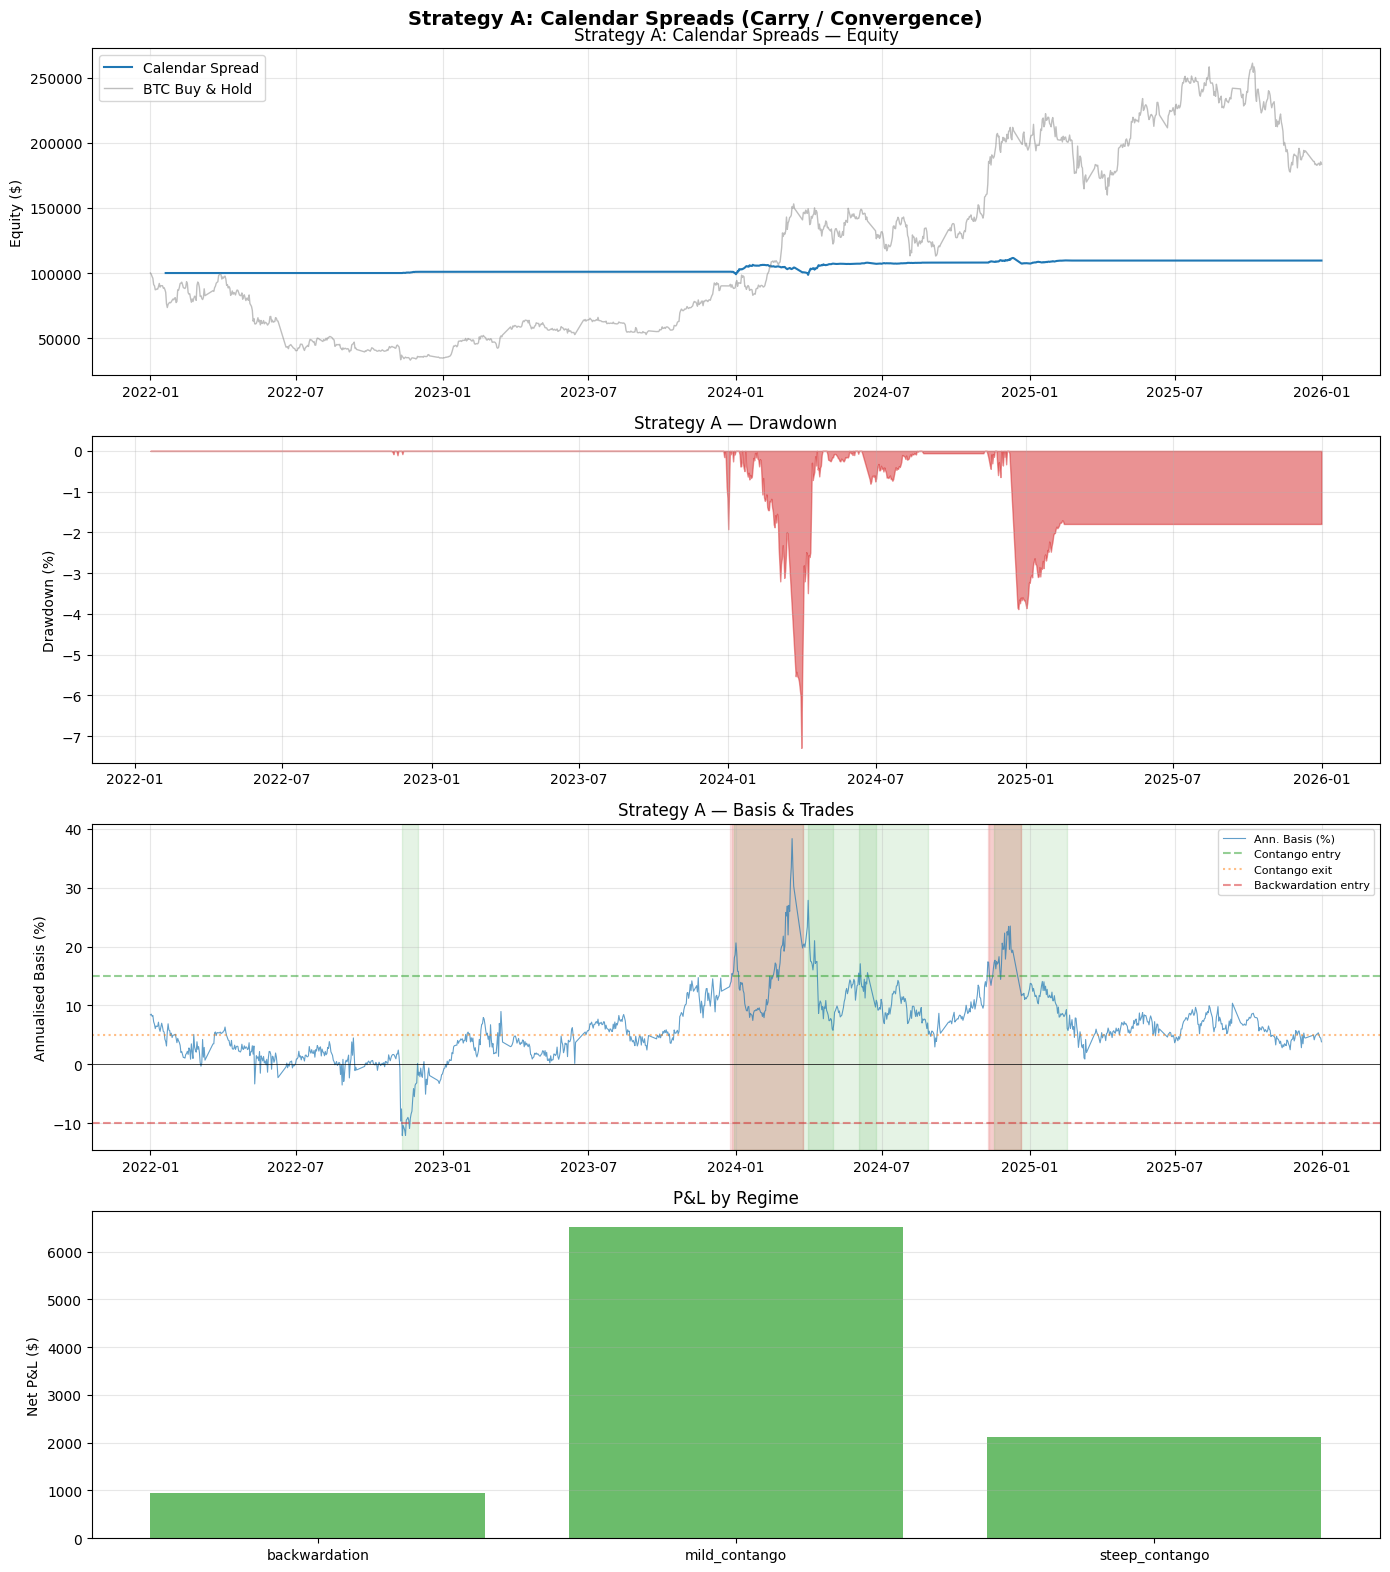

In [8]:
cfg = CalendarConfig(futures_venues="binance,deribit", margin_type="COIN-M")
result = run_calendar_spreads(dl, cfg, test_only=False)

In [9]:
result.summary()


══════════════════════════════════════════════════════════════
  A: Calendar Spreads (Carry / Convergence)
══════════════════════════════════════════════════════════════
  Total Return Pct                        9.57%
  Annualized Return Pct                   2.34%
  Sharpe Ratio                            -0.40
  Sortino Ratio                           -0.52
  Max Drawdown Pct                       -7.29%
  Calmar Ratio                             0.32
  N Trades                                    9
  Win Rate                                55.6%
  Avg Win                               2655.31
  Avg Loss                              -925.49
  Profit Factor                            3.59
  Total Pnl                             9574.61
  Total Cost                            1517.57
  Cost Drag Pct                           1.52%
  Avg Carry Collected Ann Pct             6.79%
  Avg Days Held                           74.00
  N Days Traded                            1441
  Regime Trad

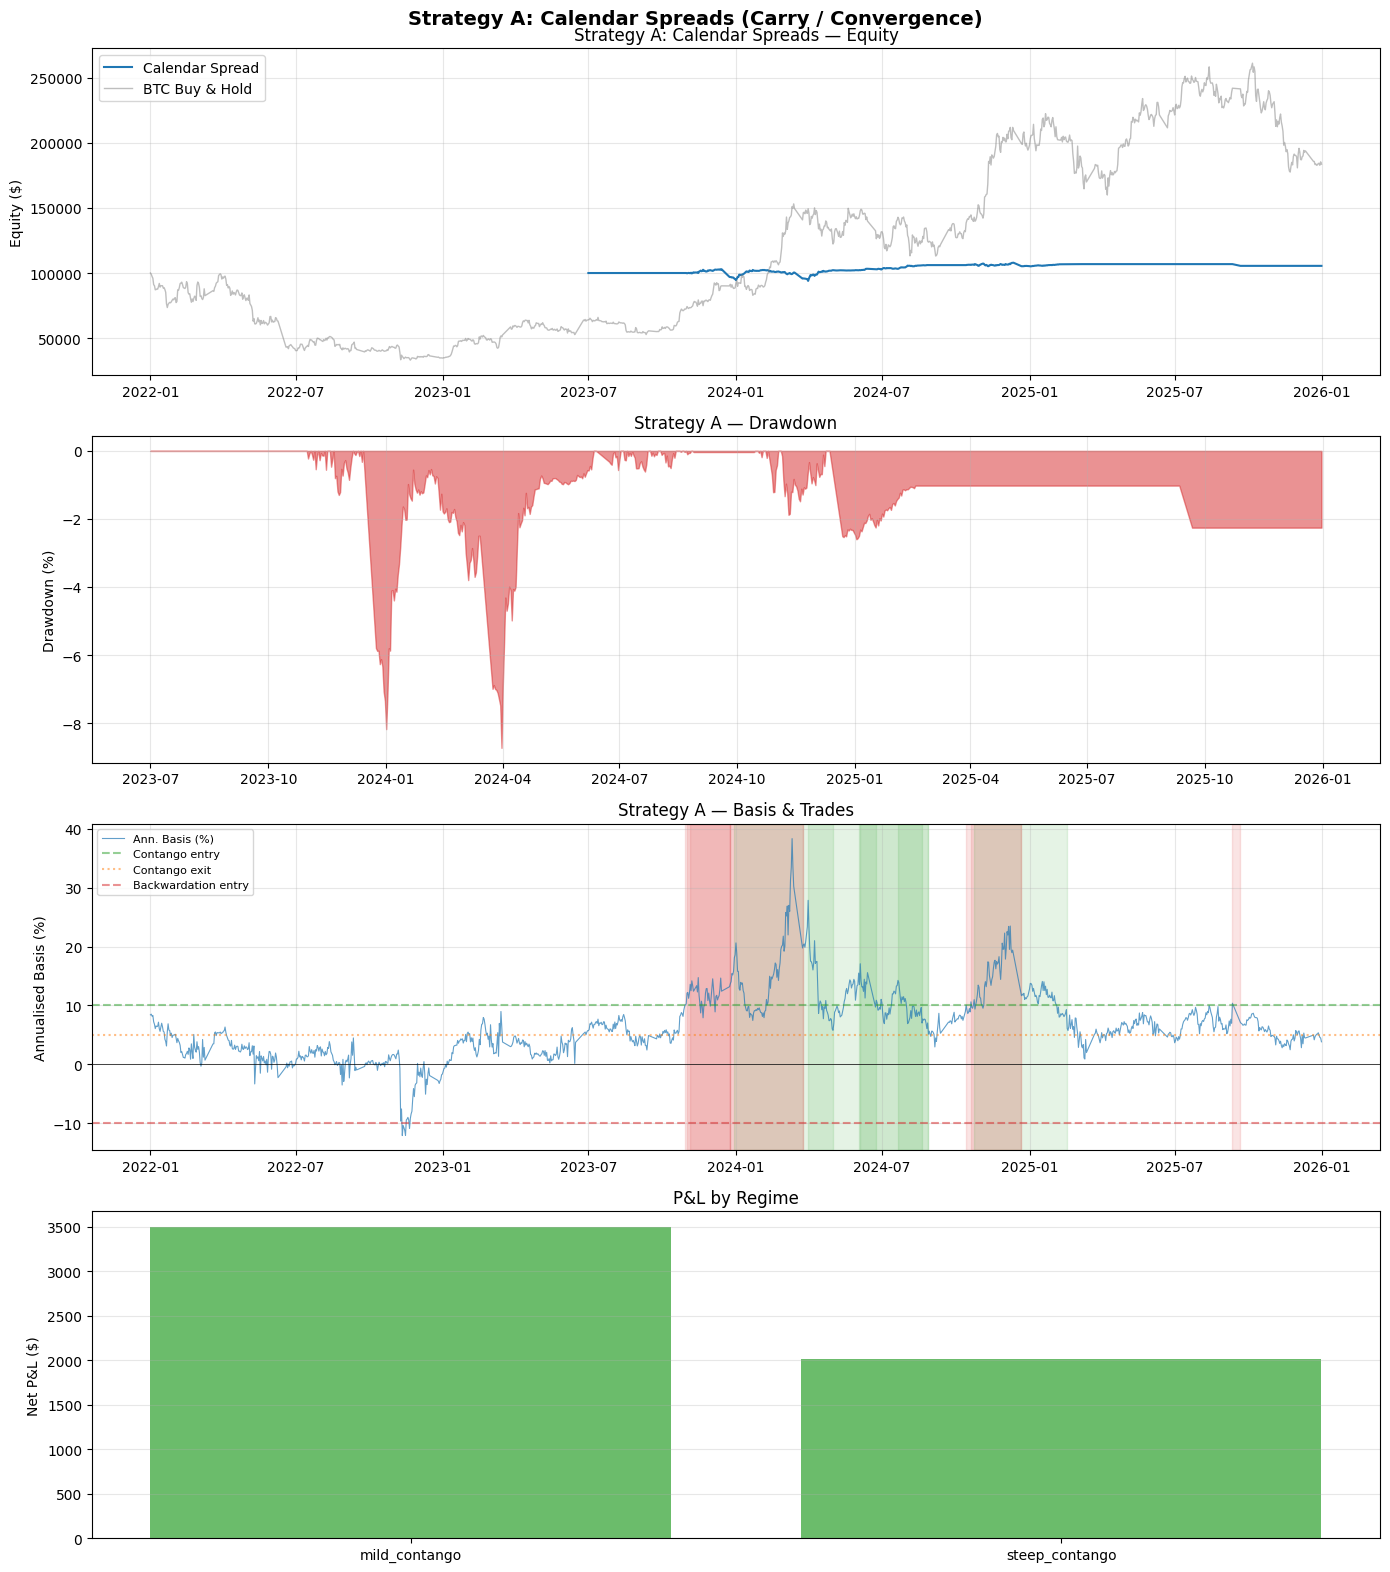

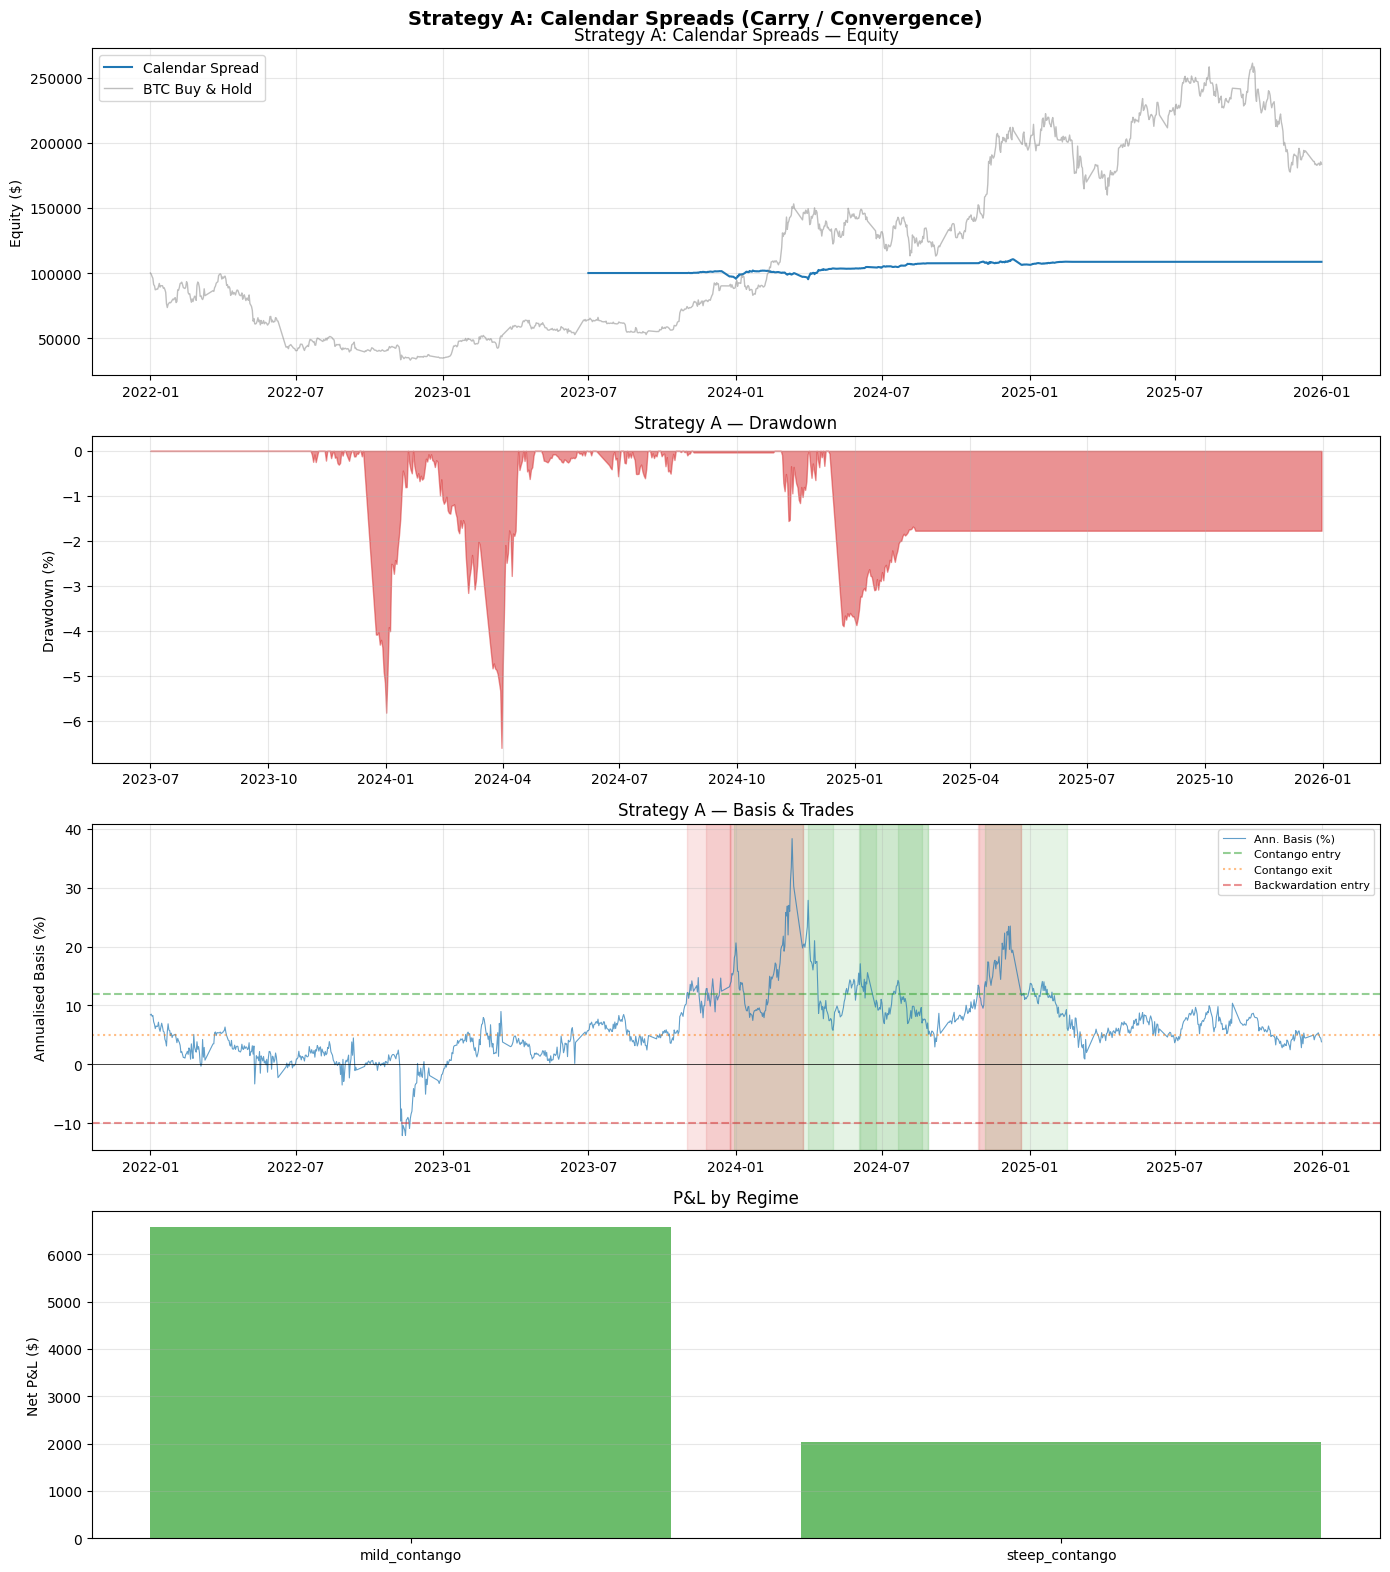

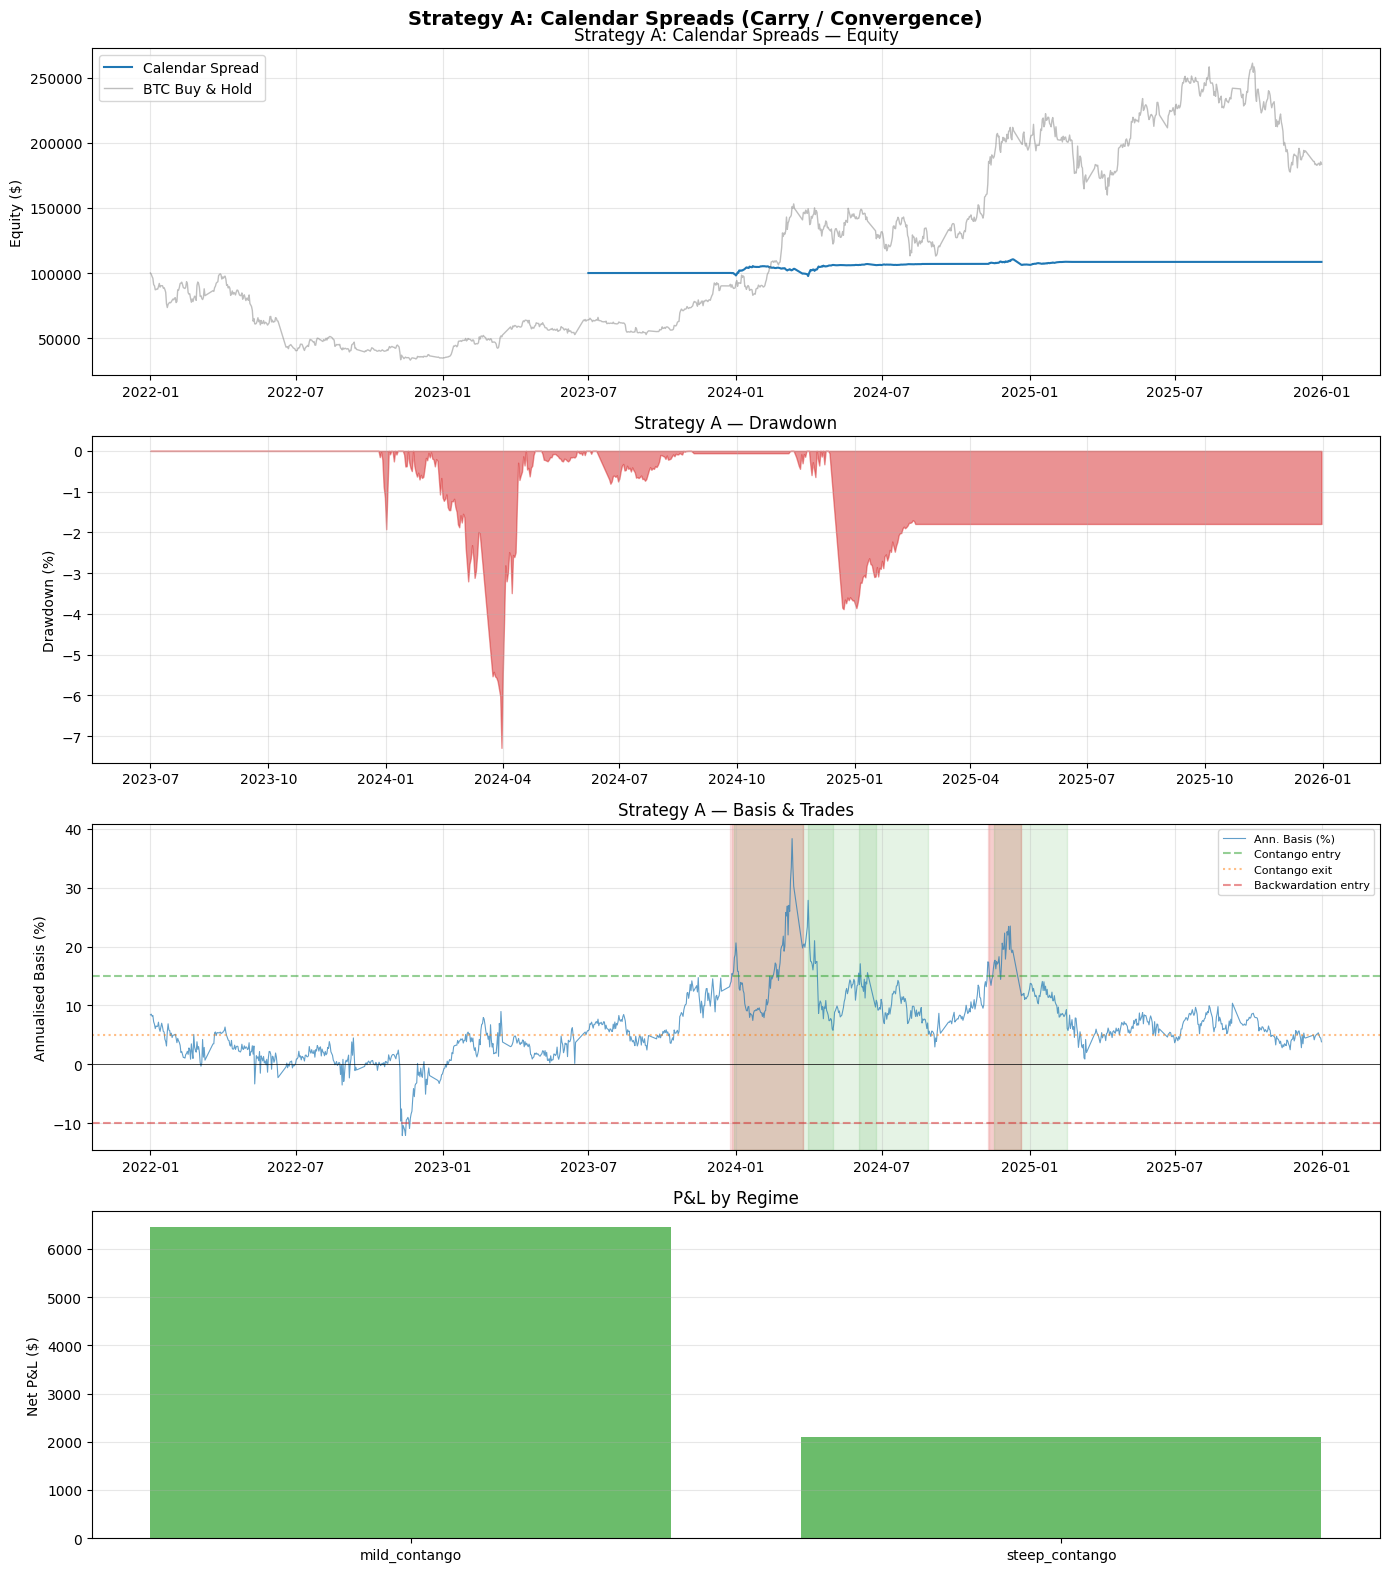

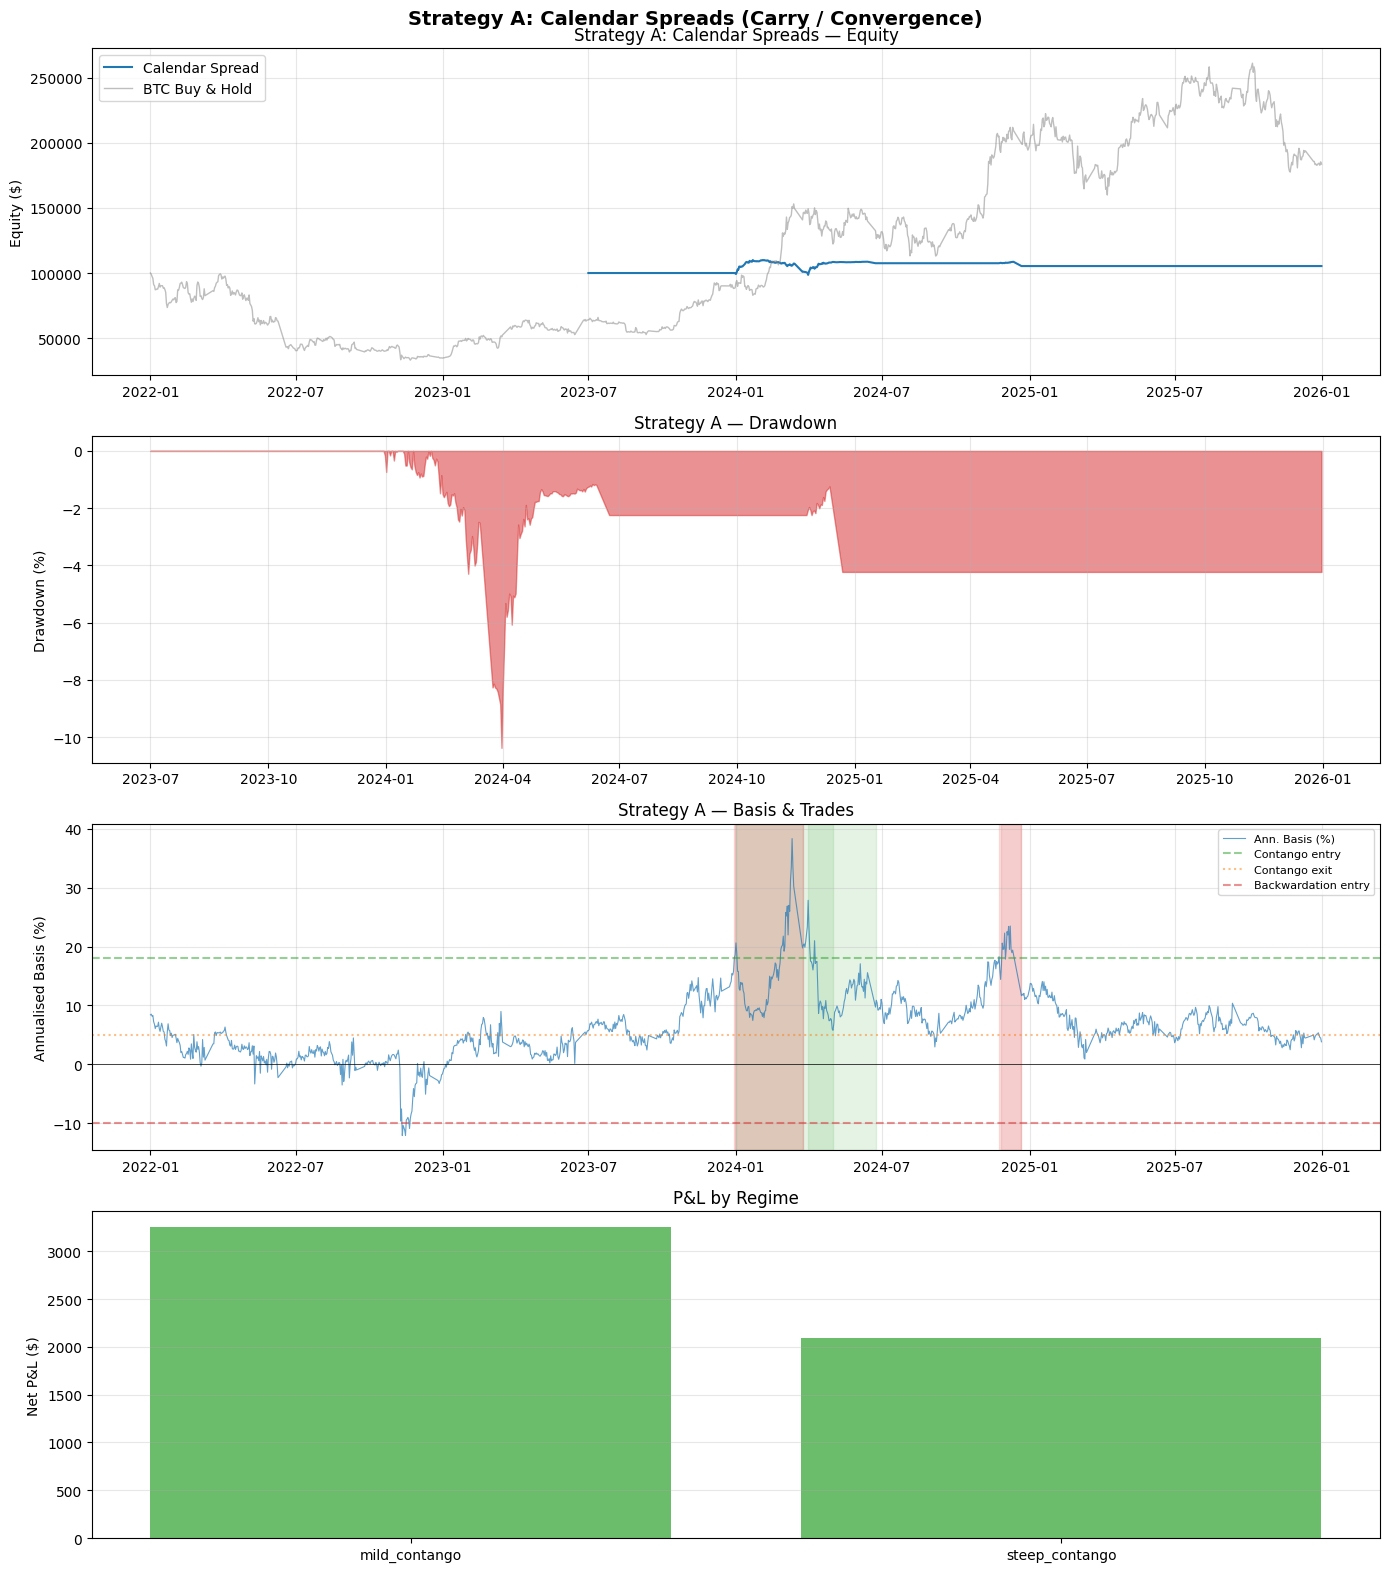

   contango_entry_ann  sharpe  return_pct  max_dd_pct  n_trades  win_rate      pnl  avg_carry
0                  10  -0.244        5.51       -8.73        13     0.462  5506.38       2.92
1                  12  -0.096        8.61       -6.60        12     0.500  8611.85       4.12
2                  15  -0.120        8.54       -7.29         8     0.500  8544.26       6.10
3                  18  -0.284        5.35      -10.38         6     0.333  5346.05       7.41


In [10]:
sens = parameter_sensitivity(dl, "contango_entry_ann", [10, 12, 15, 18], base_cfg=cfg)
print(sens.to_string())